In [1]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit.providers.fake_provider import FakeManilaV2
from squlearn import Executor
from squlearn.feature_map import ChebPQC
from squlearn.expectation_operator import SummedPaulis
from squlearn.qnn import QNNRegressor, SquaredLoss, VarianceLoss, get_variance_fac
from squlearn.optimizers import Adam

In [2]:
executor = Executor(FakeManilaV2())

Define parameterized quantum circuit $Q(x,\theta)$

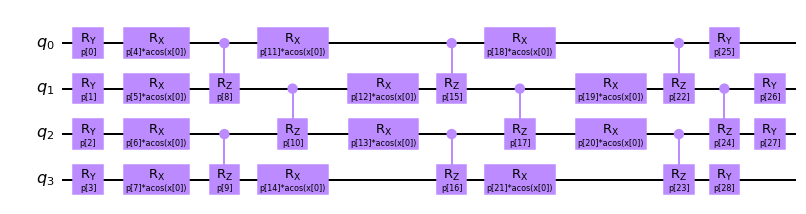

In [3]:
nqubits = 4
number_of_layers = 3
pqc = ChebPQC(nqubits, 1, num_layers=number_of_layers, closed=False)
pqc.draw()

Definition of the cost operator:
$\hat{C}(\vartheta) = \vartheta_0 \hat{I} + \sum_i \vartheta_i \hat{Z}_i $

In [4]:
cost_op = SummedPaulis(nqubits)
print(cost_op)

SparsePauliOp(['IIII', 'IIIZ', 'IIZI', 'IZII', 'ZIII'],
              coeffs=[ParameterExpression(1.0*p[0]), ParameterExpression(1.0*p[1]),
 ParameterExpression(1.0*p[2]), ParameterExpression(1.0*p[3]),
 ParameterExpression(1.0*p[4])])


Example function: $log(x)$

In [5]:
x_space = np.arange(0.1, 0.9, 0.1)
ref_values = np.log(x_space)

np.random.seed(13)
param_ini = np.random.rand(pqc.num_parameters) * 4
param_op_ini = np.ones(cost_op.num_parameters)

Optimization of the regression

In [6]:
ADAM = Adam({"maxiter_total": 100, "maxiter": 25, "lr": 0.1, "log_file": "adam_log.csv"})

reg = QNNRegressor(
    pqc,
    cost_op,
    executor,
    SquaredLoss(),
    ADAM,
    param_ini,
    param_op_ini,
    variance=get_variance_fac(0.005, 0.5, 5),
)

reg.fit(x_space, ref_values)

theta [3.11080964 0.95016488 3.29711413 3.86299679 3.89040446 1.81379699
 2.43616985 3.10210606 2.56645338 2.88807292 0.1401461  1.19379788
 0.23404997 3.42824377 1.49141611 2.71939181 1.0251198  1.39032486
 0.03765108 1.43333513 3.79637673 0.87159604 1.27756547 3.67108954
 0.12761467 0.26033815 2.519316   3.49525377 0.03486293 1.
 1.         1.         1.         1.        ]
pre-processing 0.004999876022338867
Number of circuits in the estimator: 16
Estimator run time 0.7320728302001953
post processing 0.0
Current value: 60.408968816831674
theta [3.11080964 0.95016488 3.29711413 3.86299679 3.89040446 1.81379699
 2.43616985 3.10210606 2.56645338 2.88807292 0.1401461  1.19379788
 0.23404997 3.42824377 1.49141611 2.71939181 1.0251198  1.39032486
 0.03765108 1.43333513 3.79637673 0.87159604 1.27756547 3.67108954
 0.12761467 0.26033815 2.519316   3.49525377 0.03486293 1.
 1.         1.         1.         1.        ]
pre-processing 0.007991313934326172
Number of circuits in the estimator: 8

In [7]:
reg.set_params(variance=get_variance_fac(0.005, 0.5, 5, offset=ADAM.iteration))
reg.partial_fit(x_space, ref_values)

theta [ 2.20227869  1.06497991  2.93824385  3.49002165  2.85211759  2.31907547
  2.73052407  1.96996994  1.60274456  2.97049006  0.28669721  1.426377
  0.01259095  3.0977007   0.82407452  1.89140608  1.35830605  2.16379622
 -0.93379935  2.39617579  2.75307638  1.05161725  0.86850696  3.05961097
  1.06093786  1.14983024  2.37035097  2.73127234  0.39821879 -0.77352408
  0.46916834  0.15178545 -0.19629103  1.054368  ]
Current value: 0.5629739047164388
theta [ 2.20227869  1.06497991  2.93824385  3.49002165  2.85211759  2.31907547
  2.73052407  1.96996994  1.60274456  2.97049006  0.28669721  1.426377
  0.01259095  3.0977007   0.82407452  1.89140608  1.35830605  2.16379622
 -0.93379935  2.39617579  2.75307638  1.05161725  0.86850696  3.05961097
  1.06093786  1.14983024  2.37035097  2.73127234  0.39821879 -0.77352408
  0.46916834  0.15178545 -0.19629103  1.054368  ]
pre-processing 0.011999845504760742
Number of circuits in the estimator: 80
Estimator run time 2.270306348800659
post processing

In [ ]:
reg.set_params(variance=get_variance_fac(0.005, 0.5, 5, offset=ADAM.iteration))
reg.partial_fit(x_space, ref_values)

In [ ]:
reg.set_params(variance=get_variance_fac(0.005, 0.5, 5, offset=ADAM.iteration))
reg.partial_fit(x_space, ref_values)

In [ ]:
print("Result Param:", reg.param)
print("Result ParamOp:", reg.param_op)

In [ ]:
x = np.arange(np.min(x_space), np.max(x_space), 0.005)
y = reg.predict(x)
plt.plot(x, np.log(x))
plt.plot(x, y)